In [2]:
import numpy as np
import pymc3 as pm
from pymc3 import Model, sample
import pandas as pd
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prophet import Prophet

In [3]:
from google.colab import files

file = files.upload()

Saving MMM_test_data.csv to MMM_test_data.csv


In [4]:
holiday = files.upload()

Saving prophet_holidays_daily.csv to prophet_holidays_daily.csv


### model spend carry over 
There are several ways to model the spend carry over. The commonly used transformation is a so-called adstock with geometric decay. The version of this is implemented using the decay paramenter $α$, the maximum duration of effect L and the delay of the peak effect $\theta$. 
In this exercise, the implemented the other version with just one parameter, decay rate $\alpha$. <br>
$Y_t = X_t + \alpha * Y_{t-1}$, <br> where $X_t$ is the current ad spend, $Y_{t-1}$ is the cumulative adstock effect at time t-1 and $Y_{t}$ is the final adstock at time t. <br>
One disadvantage of this approach is the we are assuming the current revenue is most impacted by the current ad spend which is not true in a real life setup. The first approach is better where we consider the delay of the peak effect.


In [5]:
def step_function_for_theano_scan(t, X, Y, alpha):
    
    ## Y_t = X_t + alpha*Y_{t-1}
    return tt.set_subtensor(Y[t], tt.sum(X + alpha * Y[t-1]))


def adstock_geometric(x, alpha):
    
    '''
    Parameters:
    x -> Time Series of desired lenghth; Make sure to include 
        elements that are required to calulate the transformed 
        x
    alpha -> decay rate     
    '''
    x = tt.as_tensor_variable(x)
    
    len_x = x.shape[0]
    #print(x.shape.eval())
    x_trans = tt.zeros_like(x)
    x_trans = tt.set_subtensor(x_trans[0], x[0])
    output, updates = theano.scan(fn = step_function_for_theano_scan,
                                  sequences = [tt.arange(1, len_x), x[1:len_x]],  
        outputs_info = x_trans,
        non_sequences = alpha,                        
        n_steps = len_x - 1
    )
   
    ## Scan saves all the output at every level of recurrsion keep the last one
    return output[-1]

An example to see the working of the ad stock function

In [6]:
x = np.array([1,2,3,4,5,6], dtype=float)
adstock_geometric(x, 0.5).eval()
#theano.function([x], adstock_geometric(x,0.5))

array([ 1.     ,  2.5    ,  4.25   ,  6.125  ,  8.0625 , 10.03125])

### Loading the CSV file of the data

In [7]:
data = pd.read_csv('MMM_test_data.csv')
channel_names = list(data.keys())[2:]
data['events'] = 'na'
data

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,events
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,na
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,na
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,na
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,na
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,na
...,...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88,na
100,31-07-22,90786.21,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98,na
101,07-08-22,105929.40,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64,na
102,14-08-22,90506.31,0.00,1043.22,10856.58,4431.13,3086.81,0.00,28622.78,na


### Loading prophet holidays file to model the trend and seasonality. 
We only work with the holidays in the Germany. We also convert the daily granulity to weekly to be compatible with our data.

In [8]:
holidays = pd.read_csv("prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [9]:
prophet_data = data.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data['events_event2'] = 0
prophet_data['events_na'] = 1
prophet_data

,ds,y,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,events,events_event2,events_na
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,na,0,1
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,na,0,1
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,na,0,1
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,na,0,1
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,na,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88,na,0,1
100,31-07-22,90786.21,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98,na,0,1
101,07-08-22,105929.40,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64,na,0,1
102,14-08-22,90506.31,0.00,1043.22,10856.58,4431.13,3086.81,0.00,28622.78,na,0,1


In [10]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [11]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3t6m57ek/11yg8kbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3t6m57ek/j4i4g588.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61573', 'data', 'file=/tmp/tmp3t6m57ek/11yg8kbe.json', 'init=/tmp/tmp3t6m57ek/j4i4g588.json', 'output', 'file=/tmp/tmp3t6m57ek/prophet_modelbrnoxeij/prophet_model-20230127063737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


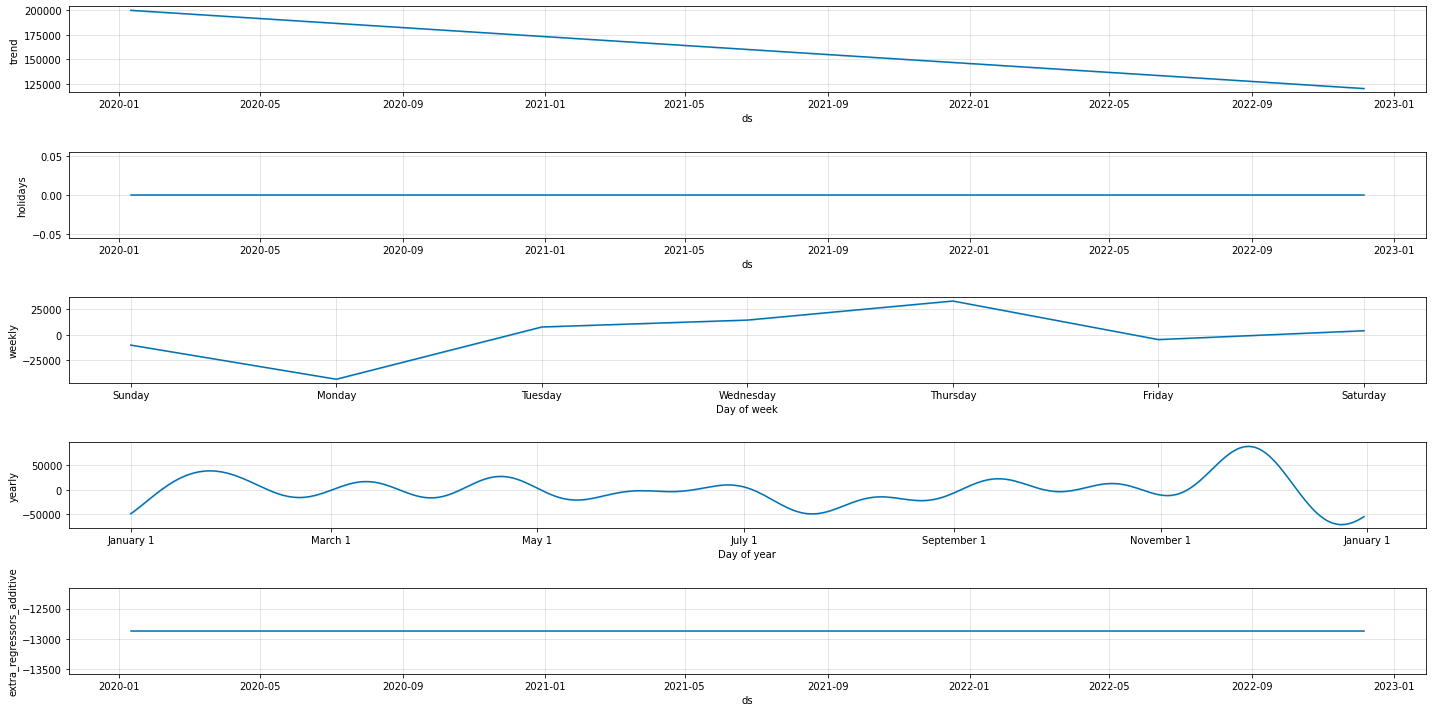

In [12]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))


In [13]:
#prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
#events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)

#final_data = data.copy()
data["trend"] = prophet_predict["trend"]
data["season"] = prophet_predict["yearly"]
#final_data["holiday"] = prophet_predict["holidays"]
#final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [14]:
data 

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,events,trend,season
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,na,200002.654472,1285.164508
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,na,193223.916374,6407.972715
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,na,188704.757643,-3568.668137
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,na,188478.799706,-2879.163801
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,na,183959.640939,-14310.226049
...,...,...,...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88,na,128223.368254,-21542.325900
100,31-07-22,90786.21,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98,na,127394.856294,-6864.607042
101,07-08-22,105929.40,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64,na,124909.320413,-3207.675864
102,14-08-22,90506.31,0.00,1043.22,10856.58,4431.13,3086.81,0.00,28622.78,na,124683.362606,-353.132977


In [15]:
control_variables = ["trend", "season"]
media_channels = channel_names
features = control_variables + media_channels
target = "revenue"

In [16]:
control_variables

['trend', 'season']

In [17]:
features

['trend',
 'season',
 'spend_channel_1',
 'spend_channel_2',
 'spend_channel_3',
 'spend_channel_4',
 'spend_channel_5',
 'spend_channel_6',
 'spend_channel_7']

### Normalizing the data

In [18]:
data_transformed = data.copy()
numerical_encoder_dict = {}
for feature in features:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler
dependent_transformation = MinMaxScaler()
original = data[target].values.reshape(-1, 1)
transformed = dependent_transformation.fit_transform(original)
data_transformed[target] = transformed

In [19]:
data_transformed    

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,events,trend,season
0,30-08-20,0.266775,0.308378,0.161313,0.160361,0.000390,0.378394,0.375721,0.146681,na,1.000000,0.450001
1,06-09-20,0.347115,0.309380,0.065121,0.064504,0.050369,0.371960,0.366196,0.192111,na,0.915094,0.482495
2,13-09-20,0.277200,0.245140,0.066158,0.027823,0.039982,0.442250,0.320874,0.193912,na,0.858491,0.419214
3,20-09-20,0.329264,0.198583,0.030235,0.211356,0.014779,0.457934,0.382581,0.225230,na,0.855660,0.423588
4,27-09-20,0.435481,0.181740,0.047575,0.287670,0.023171,0.466375,0.375230,0.251468,na,0.799057,0.351082
...,...,...,...,...,...,...,...,...,...,...,...,...
99,24-07-22,0.024831,0.000000,0.695863,0.374091,0.050654,0.069439,0.000000,0.154568,na,0.100943,0.305210
100,31-07-22,0.077692,0.000000,0.073551,0.225697,0.062715,0.078914,0.000000,0.195262,na,0.090566,0.398308
101,07-08-22,0.120352,0.000000,0.468142,0.142367,0.071419,0.102584,0.000000,0.304732,na,0.059434,0.421504
102,14-08-22,0.076904,0.000000,0.648681,0.112419,0.043565,0.072511,0.000000,0.282413,na,0.056604,0.439610


### Modeling 
Explain your choice of prior inputs to the model? <br>
The choice of the prior is based on the paper "Bayesian Methods for Media Mix Modeling with Carryover and
Shape Effects". The prior on adstock is a beta distribution. The regression coefficients are Half noraml distribution to force the samples to be positive.
The intercept chosen is a normal distribtuion with mean equal to average of revenue. 


In [20]:
per_channel = []
with pm.Model() as model:
    #beta = pm.HalfCauchy("beta", beta=10)

    for name in media_channels:
        print(f"Adding media: {name}")
  
        x = data_transformed[name].values
        #print(x)
        #alpha_adstock = pm.Normal(f"{name}_alpha_geo", 3, 3)
        #alpha_adstock = pm.HalfCauchy(f"{name}_alpha_geo", 3)
        alpha_adstock = pm.Beta(f"{name}_adstock", 3, 3)
        x_trans = adstock_geometric(x, alpha_adstock)
        #print(x_trans)
        channel_coeff = pm.HalfNormal(f"{name}_coef", sd = 3)
        per_channel.append(x_trans * channel_coeff)

    for control_var in control_variables:
        print(f"Adding control var: {control_var}")
        
        x = data_transformed[control_var].values
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        per_channel.append(control_x)    
   
    #print((per_channel))
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("revenue", mu = intercept + sum(per_channel), sd = sigma, observed = data_transformed[target].values)

Adding media: spend_channel_1
Adding media: spend_channel_2
Adding media: spend_channel_3
Adding media: spend_channel_4
Adding media: spend_channel_5
Adding media: spend_channel_6
Adding media: spend_channel_7
Adding control var: trend
Adding control var: season


### Sampling from the prior distribution

In [24]:
with model:
    prior_pred = pm.sample_prior_predictive()

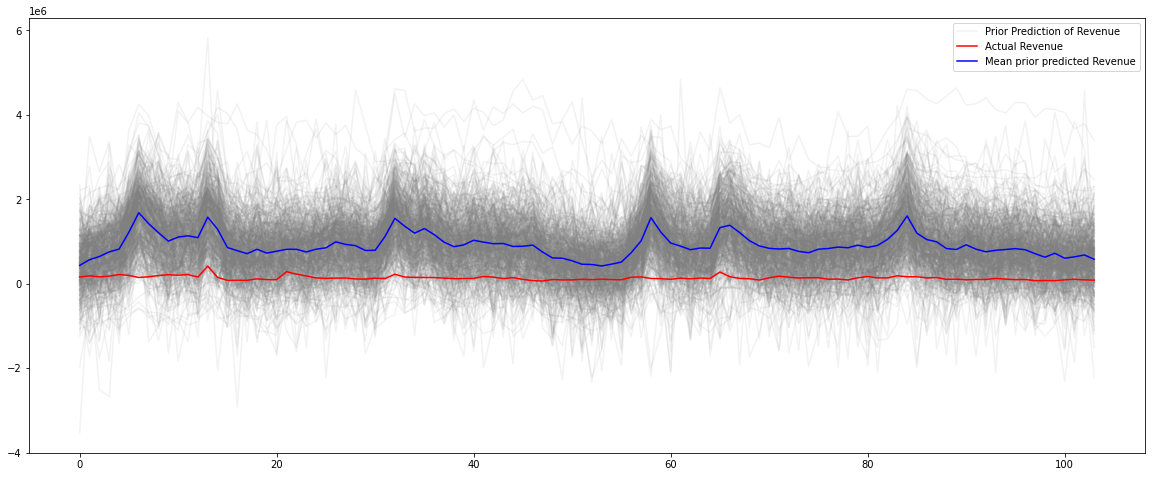

In [25]:
prior_pred = 100000*prior_pred['revenue']   
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred.T, color = "0.5", alpha = 0.1, label = 'Prior Prediction of Revenue')
_ = ax.plot(data[target].values, color = "red", label = 'Actual Revenue')
_ = ax.plot(prior_pred.mean(0), color = "blue", label = 'Mean prior predicted Revenue')
#remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)

plt.legend(newHandles, newLabels)

### Fit the model

In [26]:
with model:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

### Sampling from the posterior distribution

In [29]:
with model:
    post_pred = pm.sample_posterior_predictive(
        trace, var_names=["revenue"] + list(trace_summary.index), random_seed=42
    )

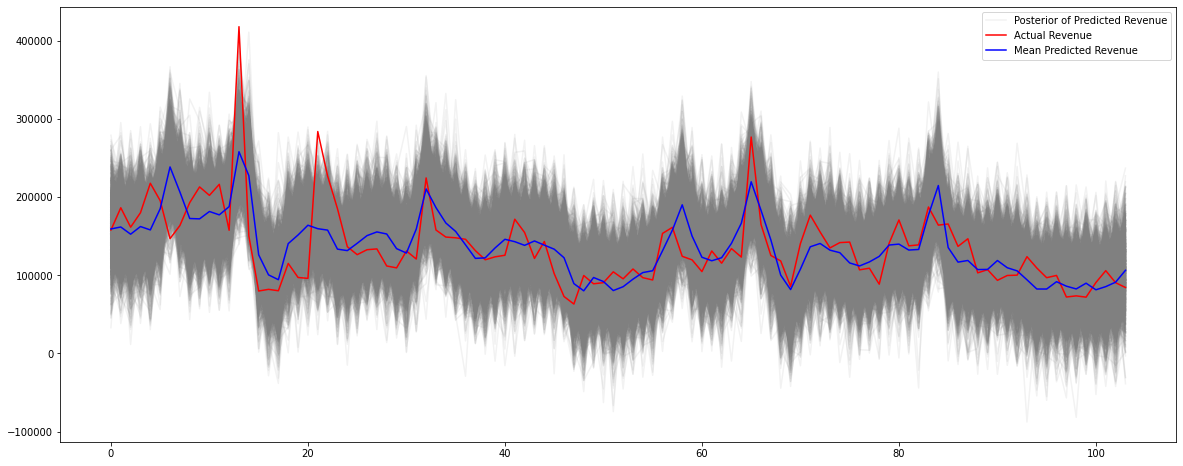

In [58]:
prediction_posterior = dependent_transformation.inverse_transform(post_pred['revenue'].T)

prediction_posterior_mean = dependent_transformation.inverse_transform(post_pred["revenue"].mean(axis = 0).reshape(-1, 1)).reshape(-1)

fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prediction_posterior, color = "0.5", alpha = 0.1, label = 'Posterior of Predicted Revenue')
_ = ax.plot(data['revenue'].values, color = "red", label='Actual Revenue')   
_ = ax.plot(prediction_posterior_mean, color = "blue", label = 'Mean Predicted Revenue')

#remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)

plt.legend(newHandles, newLabels)

#az.plot_ppc(az.from_pymc3(posterior_predictive=post_pred, model=model), var_names = ["pred"])

### Performance of the model
How good is your model performing? How you do measure it?
The model performance is measured with Root mean square error (RMSE) and normalized root mean square error (NRMSE). 

In [59]:
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

In [61]:
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    #mean_variable = ppc_all[variable].mean()
    mean_variable = trace.posterior[variable].mean(axis = 0).mean().values
    #print(mean_variable)
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data['revenue'].values
y_pred = prediction_posterior.T.mean(0)

print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

RMSE: 34974.772267171065
MAPE: 0.1818524754359818
NRMSE: 0.09852623308579794


In [62]:
trace_summary

,old_mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,old_mean,old_mean,mean
trend_control_coef,0.260,0.086,0.101,0.420,0.003,0.002,1155.0,1521.0,1.0,0.259836,0.259836,0.259836
season_control_coef,0.262,0.063,0.142,0.380,0.001,0.001,2857.0,1344.0,1.0,0.261875,0.261875,0.261875
intercept,-0.198,0.055,-0.298,-0.092,0.002,0.001,1210.0,1365.0,1.0,-0.197593,-0.197593,-0.197593
spend_channel_1_adstock,0.460,0.191,0.135,0.821,0.004,0.003,2835.0,1286.0,1.0,0.460221,0.460221,0.460221
spend_channel_1_coef,0.019,0.019,0.000,0.054,0.000,0.000,1565.0,1024.0,1.0,0.019060,0.019060,0.019060
spend_channel_2_adstock,0.433,0.192,0.109,0.793,0.004,0.003,2056.0,1078.0,1.0,0.432982,0.432982,0.432982
spend_channel_2_coef,0.074,0.047,0.000,0.155,0.001,0.001,977.0,499.0,1.0,0.074111,0.074111,0.074111
spend_channel_3_adstock,0.330,0.164,0.064,0.643,0.004,0.003,2109.0,1026.0,1.0,0.330069,0.330069,0.330069
spend_channel_3_coef,0.111,0.054,0.000,0.199,0.001,0.001,1372.0,742.0,1.0,0.110928,0.110928,0.110928
spend_channel_4_adstock,0.434,0.192,0.107,0.793,0.004,0.003,2973.0,1290.0,1.0,0.434166,0.434166,0.434166


###What are your main insights in terms of channel performance/ effects?
From the trace summmary we can see that the mean of all the spending channel coefficient are very small and hence does not affect the revenue a lot. Trend and seasonality has a larger role to play. 
